## Задание 1. Свёртка

**5 баллов**

Реализуйте функцию свёртки `conv(x, kernel, stride, pad)`, где:


* $\text{x}$: Двумерный массив размером $(W,H)$;
* $\text{kernel}$: ядро свёртки размером $(K, K)$;
* $\text{stride}$: шаг ядра свёртки. $0 < \text{stride} \leq \min(W,H)$;
* $\text{pad}$: ширина дополнения с каждой из сторон массива. $\text{pad} > 0$.

Результатм работы функции является возвращение следующего значения:
* $out$: Результат свертки входных данных $\text{x}$, имеющий размер $(H', W')$: 
  - $H' = 1 + (H + 2 \cdot pad - K)\ //\  stride$;
  - $W' = 1 + (W + 2 \cdot pad - K)\  //\ stride$.

---

Воспользуйтесь созданной функцией `conv` для применения [оператора Собеля](https://ru.wikipedia.org/wiki/%D0%9E%D0%BF%D0%B5%D1%80%D0%B0%D1%82%D0%BE%D1%80_%D0%A1%D0%BE%D0%B1%D0%B5%D0%BB%D1%8F) 
к изображению, после чего выведите результат на экран.

Можно работать и с `numpy`, и с `torch`, как вам угодно.

In [1]:
import torch
import numpy as np

In [2]:
# Можете тренироваться на этом примере
a = np.arange(9).reshape((3, 3))
M = np.block([[a, a],[a, a]])
print(M)

[[0 1 2 0 1 2]
 [3 4 5 3 4 5]
 [6 7 8 6 7 8]
 [0 1 2 0 1 2]
 [3 4 5 3 4 5]
 [6 7 8 6 7 8]]


In [73]:
def padding_img(img: np.ndarray, pad_size = 1) -> np.ndarray:
    '''
    Apply padding to the image
    Parameters
    ----------
    x : numpy.ndarray
        The input numpy array of image.

    Returns
    -------
    numpy.ndarray
        The padding numpy array of image.
    '''
    new_shape = np.array(img.shape) + 2*pad_size
    new_img = np.zeros(new_shape)
    new_img[pad_size:len(new_img)-pad_size, pad_size:len(new_img)-pad_size] = img
    return new_img


In [77]:
def conv_operation(img, kernel, stride):
    kernel_size = kernel.shape[0]
    assert kernel_size % stride == 0 # kernel_size должен быть кратен stride, иначе мы не покроем все изображение
    all_idx = []
    for i in range(kernel_size, img.shape[0]+1, stride):
        all_idx.append((i-kernel_size, i))   # собираем индексы по которым будем ходить
    kernel_vector = kernel.flatten()
    activation_map = []
    for horiz_idx in all_idx:
        curent_row = []
        for vertic_idx in all_idx:
            st_h, end_h = horiz_idx
            st_v, end_v = vertic_idx
            vector_patch = img[st_h:end_h, st_v:end_v].flatten()
            res = np.dot(vector_patch, kernel_vector)
            curent_row.append(res)
        activation_map.append(curent_row)
    return np.array(activation_map)




In [95]:
def conv(x, kernel, stride, pad):
    # YOUR CODE IS HERE
    x = padding_img(x, pad_size = pad)
    activation_map = conv_operation(x, kernel, stride)
    return activation_map

In [63]:
sobel_kernel_vert = np.array([
                                  [-1, 0, 1],
                                  [-2, 0, 2],
                                  [-1, 0, 1]
])


sobel_kernel_hor = np.array([
                                 [-1, -2, -1],
                                 [0, 0, 0],
                                 [1, 2, 1]
])

Примените эти два фильтра к следующей картинке и нарисуйте полученные результаты:

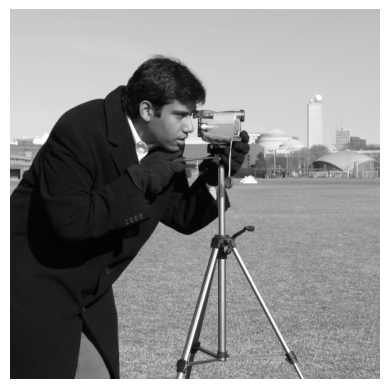

In [59]:
from skimage import data
import matplotlib.pyplot as plt

camera = data.camera()
plt.figure()
plt.imshow(camera.astype("int"), cmap="gray", vmin=0, vmax=255)
plt.axis("off");

In [78]:
camera.astype("int").shape

(512, 512)

In [79]:
camera.shape

(512, 512)

In [91]:
camera_s_vert_filter = conv(camera, sobel_kernel_vert, stride = 1, pad = 2)

In [92]:
camera_s_vert_filter.shape

(514, 514)

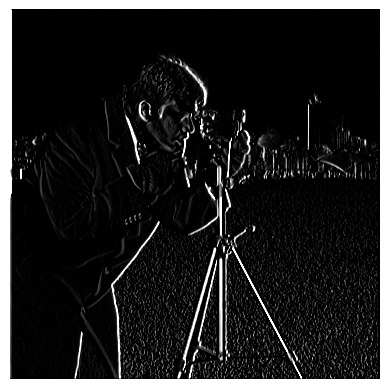

In [93]:
plt.figure()
plt.imshow(camera_s_vert_filter, cmap="gray", vmin=0, vmax=255)
plt.axis("off");

In [89]:
camera_s_hor_filter = conv(camera, sobel_kernel_hor, stride = 1, pad = 2)

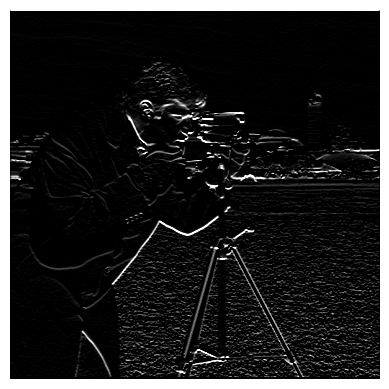

In [90]:
plt.figure()
plt.imshow(camera_s_hor_filter, cmap="gray", vmin=0, vmax=255)
plt.axis("off");

Допишите код ниже и проинтерпретируйте полученный результат:

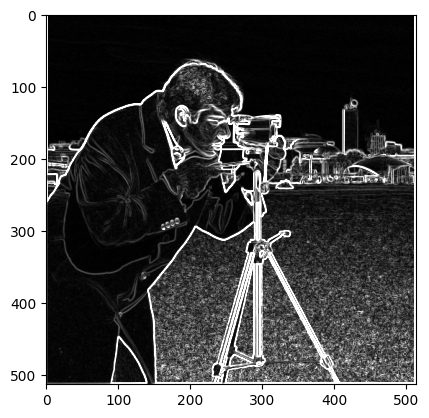

In [94]:

camera_with_borders = np.sqrt(camera_s_hor_filter**2 + camera_s_vert_filter**2)
plt.imshow(camera_with_borders, cmap="gray", vmin=0, vmax=255);

### Отдельные фильтры выделяют разные паттерны в изображении, два фильтра смогли выделить вертикальные и горизонтальные линии в изображении. 
### Их объединение позволило выделить выделюящие контуры в изображении. 

## Задание 2. AlexNet

**15 баллов**

Воссоздайте архитектуру `AlexNet` для определения заболевания растения. Датасеты уже созданы ниже.

In [ ]:
INPUT_IMAGE_SIZE = 227
BATCH_SIZE = 64
N_EPOCHS = 10 # можно будет при желании увеличить
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from IPython.display import clear_output

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose, ToPILImage
from torchvision.transforms import Normalize, Resize

from glob import glob
from torch import nn
from torch.nn import functional as F
import torch
import os
 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
!wget https://storage.googleapis.com/ibeans/train.zip
!wget https://storage.googleapis.com/ibeans/validation.zip
!wget https://storage.googleapis.com/ibeans/test.zip

clear_output()

In [ ]:
!unzip train.zip
!unzip validation.zip
!unzip test.zip

clear_output()

In [ ]:
class BeanDataset(Dataset):e
    def __init__(self, img_dir, side_size=INPUT_IMAGE_SIZE):
        # папка с картинками
        self.img_dir = img_dir
        # отсортированный список с названиями файлов
        self.files = sorted(glob(f'{img_dir}/*/*.jpg'))
        class_names = sorted(os.listdir(img_dir))
        # названия папок с картинками переведем в номера классов
        self.class_dir = {name:idx for idx, name in enumerate(class_names)}
        self._number_to_labels = {idx:name for idx, name in enumerate(class_names)}

        # трансформации данных: мы изменяем размер,
        # так как AlexNet работает с картинками 227 на 227 пикселей
        self.transforms = Compose([ToPILImage(),
                                  Resize(side_size),
                                  ToTensor(),
                                  Normalize(
                                      mean = [0.5183, 0.4845, 0.6570],
                                      std = [0.2111, 0.2227, 0.2291]
                                  )])
        self._transforms_for_plot = Compose([ToPILImage(),
                                  Resize(side_size),
                                  ToTensor()
                                  ])


    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx, normalize=True):
        file_path = self.files[idx]
        image = read_image(file_path).type(torch.DoubleTensor)

        # применяем трансформации
        if normalize:
            transformed_img = self.transforms(image)
        
        transformed_img = self._transforms_for_plot(image)
        
        label_name = file_path.split('/')[-2]
        label = self.class_dir[label_name]
        
        # как обычно возвращаем картинку и номер класса
        return transformed_img, label

In [ ]:
train_dataset = BeanDataset("./train/")
valid_dataset = BeanDataset("./validation/")
test_dataset = BeanDataset("./test/")

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
train_dataset.class_dir, valid_dataset.class_dir, test_dataset.class_dir  # три класса

({'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
 {'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2},
 {'angular_leaf_spot': 0, 'bean_rust': 1, 'healthy': 2})

Посмотрим на наши картинки:

(код довольно эзотерический, но у меня было такое настроение)

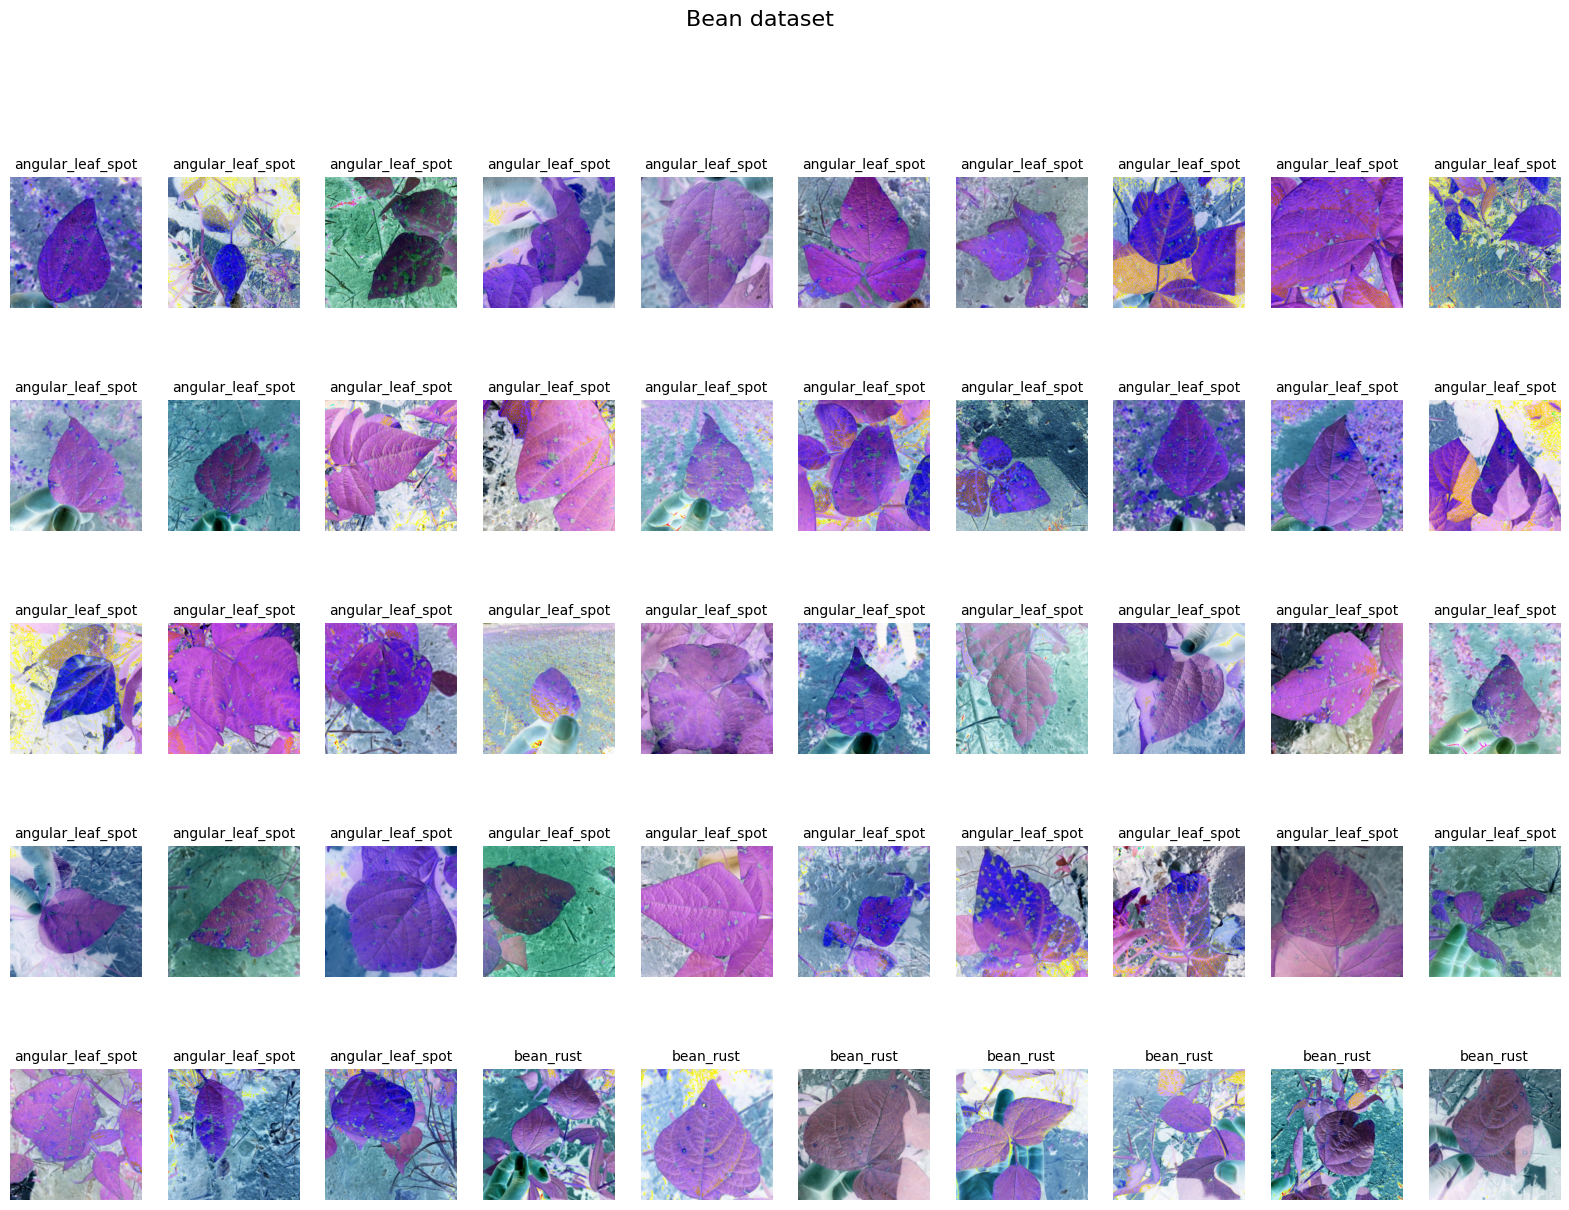

In [ ]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(20, 14))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.__getitem__(index, normalize=False)[0].permute(1, 2, 0))
    title = valid_dataset._number_to_labels[valid_dataset.__getitem__(index, normalize=False)[1]]
    plt.title(title, fontsize=10)
    
fig.suptitle("Bean dataset", fontsize=16);

### Реализация `AlexNet`

В лекции мы познакомились с архитектурой `AlexNet`, теперь пришло время реализовать ее самостоятельно. Важно, что на выходе число классов у нас будет сильно меньше чем 1000, нужно будет в начале это определить. Везде в качестве активации используется `ReLU`.

Также обратите внимание на параметры пулинга, тут ядро 3х3 со страйдом 2 (поэтому он называется overlapping).

Картинка может немного отличаться от того, что было на лекции, ориентируйтесь на картинку в ноутбуке.

Внимательно смотрите на параметры сверток (например, padding / stride).

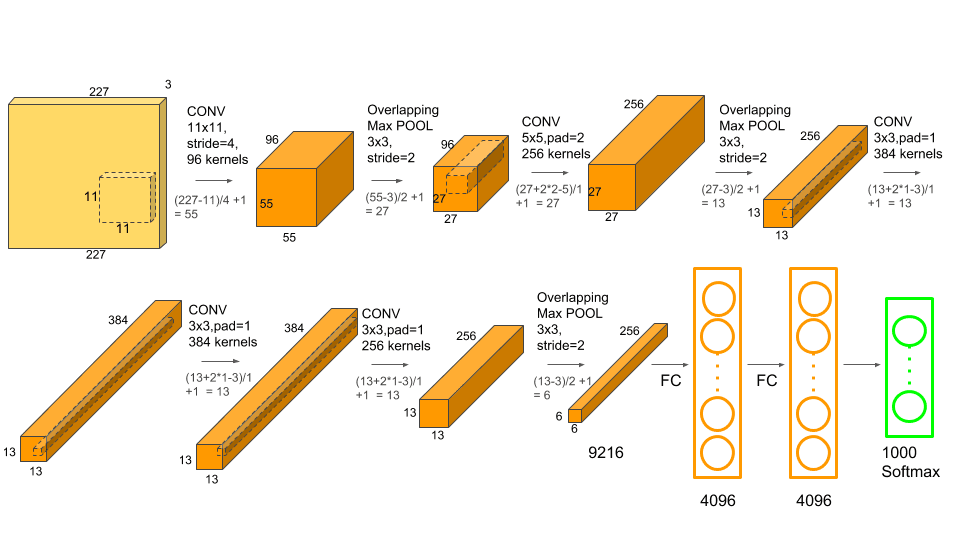

In [ ]:
N_CLASSES = 3 # определите число классов в данных
LEARNING_RATE = 3e-4 # можно подобрать как-то другой)

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes = N_CLASSES):
        super().__init__()
        self.conv_1 = nn.Sequential(nn.Conv2d(3, 96, 11, stride=4), nn.ReLU(), nn.MaxPool2d(3, stride=2))
        self.conv_2 = nn.Sequential(nn.Conv2d(96, 256, 5, stride=1, padding=2), nn.ReLU(), nn.MaxPool2d(3, stride=2))
        self.conv_3 = nn.Sequential(nn.Conv2d(256, 384, 3, stride=1, padding=1), nn.ReLU())
        self.conv_4 = nn.Sequential(nn.Conv2d(384, 384, 3, stride=1, padding=1), nn.ReLU())
        self.conv_5 = nn.Sequential(nn.Conv2d(384, 256, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(3, stride=2))
        self.linear = nn.Sequential(nn.Linear(9216, 4096), nn.ReLU(), nn.Linear(4096, 4096), nn.ReLU(), nn.Linear(4096, 3))
        self.softmax = nn.Softmax(dim = -1)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.conv_5(x)
        x = x.flatten(1)
        logits = self.linear(x)
        probs = self.softmax(logits)
        return logits, probs

Возьмите код для обучения и валидации модели, который был на лекции (если захочется, то его можно как угодно менять). В лекции мы возвращали из модели помимо логитов еще и вероятности классов, чтобы потом рисовать красивые картинки. Если захотите сделать также, то учтите это.

In [ ]:
def train_epoch(train_loader, model, criterion, optimizer, device):
    """
    Function for the training step of the training loop
    """

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss


def validate_epoch(valid_loader, model, criterion, device):
    """
    Function for the validation step of the training loop
    """
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss


def get_accuracy(model, dataloader, device):
    """
    model - 
    dataloader - 
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy


def plot_losses(train_losses, valid_losses):
    sns.lineplot(x=np.arange(1, len(train_losses)+1), y=train_losses, label="Train Loss")
    sns.lineplot(x=np.arange(1, len(train_losses)+1), y=valid_losses, label="Validation Loss")


def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    """
    Function defining the entire training loop
    """

    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train_epoch(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate_epoch(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, train_losses, valid_losses

Выберите функцию потерь и оптимизатор и обучите полученную модель на тренировочных данных, параллельно проверяя ее на валидационной части:

In [ ]:
model = AlexNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

05:32:42 --- Epoch: 0	Train loss: 1.1049	Valid loss: 1.0944	Train accuracy: 33.37	Valid accuracy: 33.08
05:33:11 --- Epoch: 1	Train loss: 1.0841	Valid loss: 1.0969	Train accuracy: 33.85	Valid accuracy: 33.83
05:33:42 --- Epoch: 2	Train loss: 1.0486	Valid loss: 1.0321	Train accuracy: 44.78	Valid accuracy: 43.61
05:34:11 --- Epoch: 3	Train loss: 0.9975	Valid loss: 1.0427	Train accuracy: 50.39	Valid accuracy: 48.87
05:34:40 --- Epoch: 4	Train loss: 0.8773	Valid loss: 1.0467	Train accuracy: 58.12	Valid accuracy: 54.14
05:35:09 --- Epoch: 5	Train loss: 0.8335	Valid loss: 0.7642	Train accuracy: 72.15	Valid accuracy: 72.93
05:35:39 --- Epoch: 6	Train loss: 0.8527	Valid loss: 0.9450	Train accuracy: 52.80	Valid accuracy: 51.88
05:36:09 --- Epoch: 7	Train loss: 0.8013	Valid loss: 0.8697	Train accuracy: 65.47	Valid accuracy: 63.16
05:36:37 --- Epoch: 8	Train loss: 0.7106	Valid loss: 0.9013	Train accuracy: 62.96	Valid accuracy: 60.90
05:37:07 --- Epoch: 9	Train loss: 0.7047	Valid loss: 0.6954	Trai

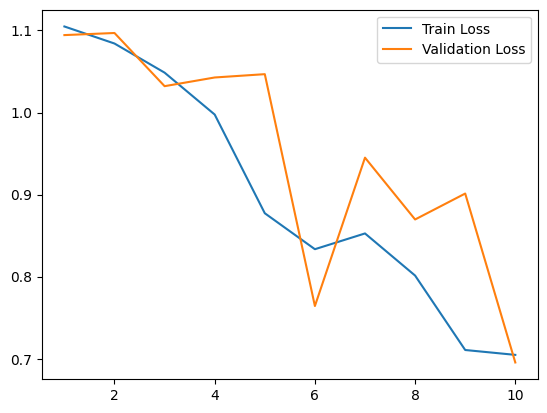

In [ ]:
model, train_losses, val_losses = training_loop(model, criterion, optimizer, trainloader, validloader, N_EPOCHS, DEVICE)

Лосс на валидации падает, можно доучить еще.

In [ ]:
N_EPOCHS = 5

In [ ]:
model.to(DEVICE)

AlexNet(
  (conv_1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv_4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv_5): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=4

05:59:50 --- Epoch: 0	Train loss: 0.6485	Valid loss: 0.6890	Train accuracy: 75.63	Valid accuracy: 73.68
06:00:19 --- Epoch: 1	Train loss: 0.6145	Valid loss: 0.6566	Train accuracy: 78.05	Valid accuracy: 75.94
06:00:49 --- Epoch: 2	Train loss: 0.5357	Valid loss: 0.6969	Train accuracy: 72.44	Valid accuracy: 66.92
06:01:19 --- Epoch: 3	Train loss: 0.5510	Valid loss: 0.6149	Train accuracy: 76.69	Valid accuracy: 76.69
06:01:48 --- Epoch: 4	Train loss: 0.5456	Valid loss: 0.6297	Train accuracy: 79.30	Valid accuracy: 78.95


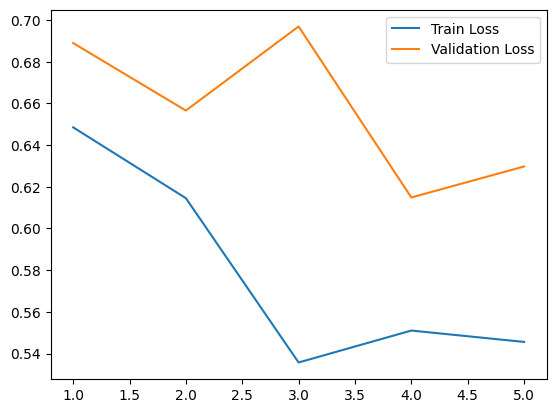

In [ ]:
model, train_losses, val_losses = training_loop(model, criterion, optimizer, trainloader, validloader, N_EPOCHS, DEVICE)

Если вы все реализовали правильно, то `accuracy` на валидации должна быть в районе 0.8.

### Визуализация предсказаний

Визуализируем предсказания нашей модели и степень уверенности в них. Сделайте выводы о качестве полученной модели.

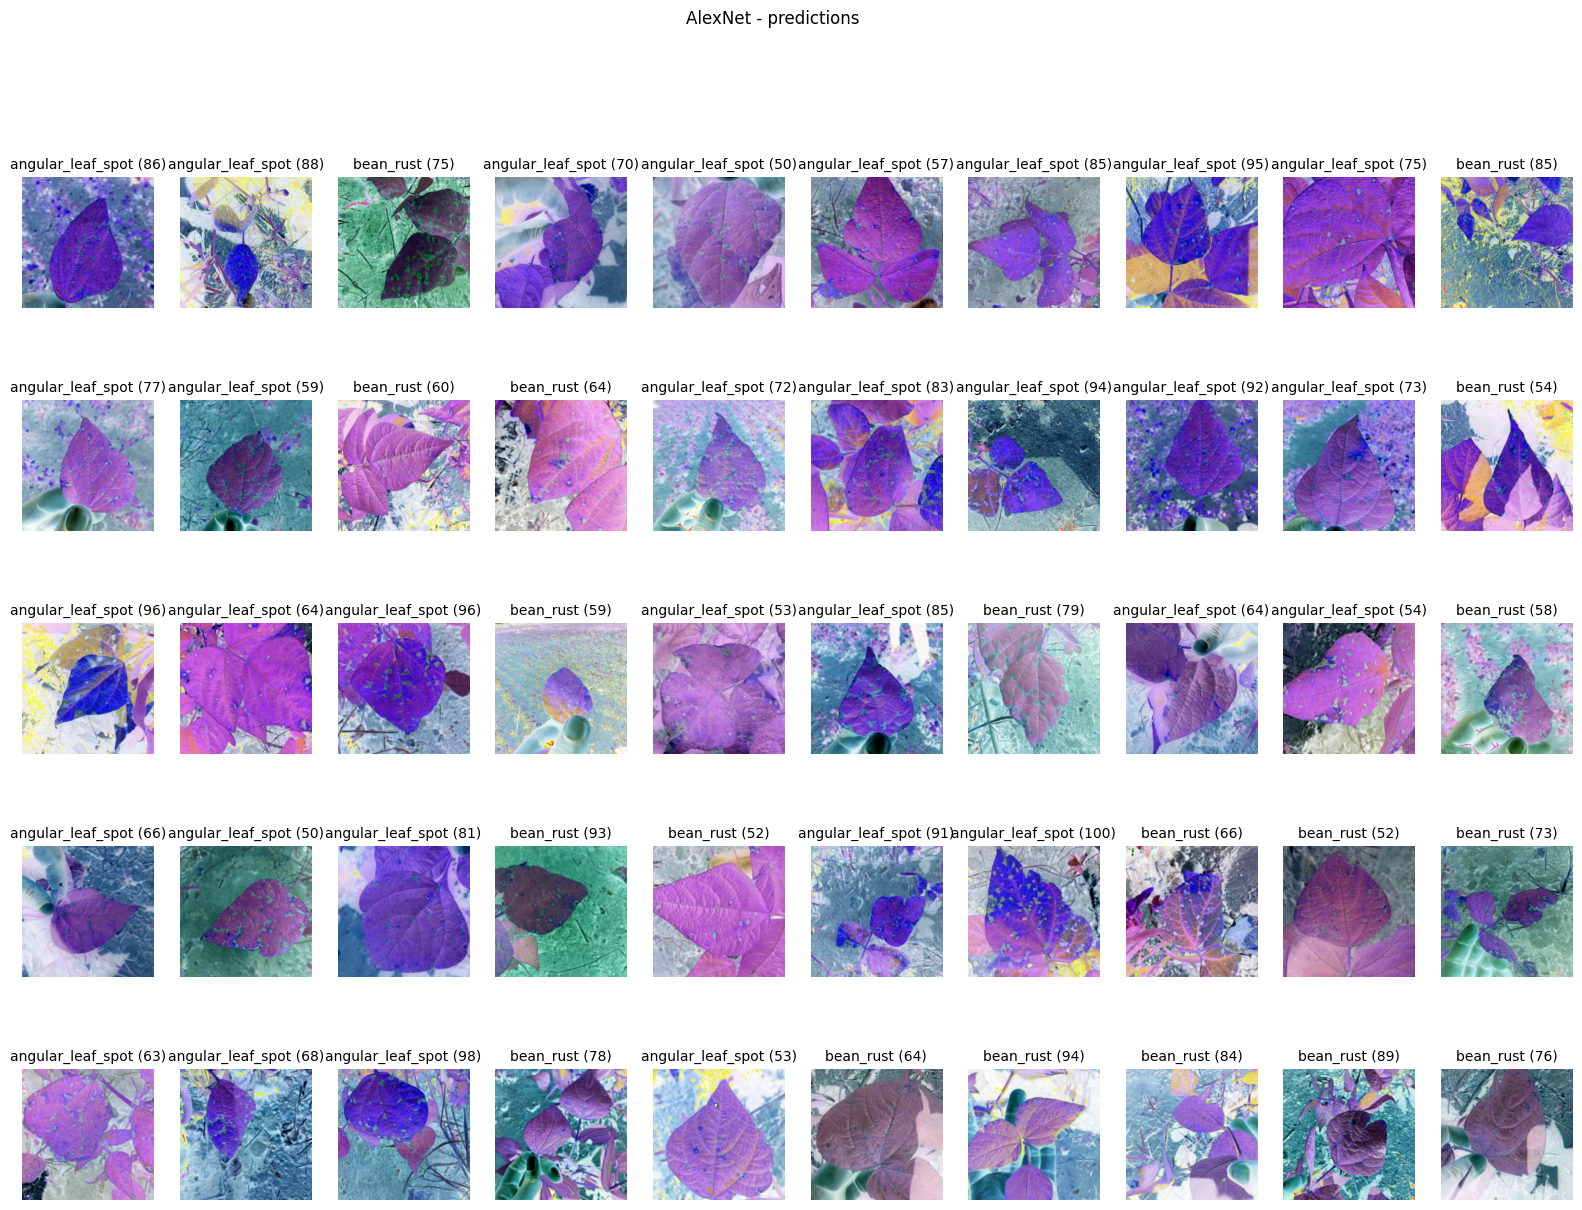

In [ ]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(20, 14))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.__getitem__(index, normalize=False)[0].permute(1, 2, 0))
    
    with torch.no_grad():
        # error)
        model.cpu().eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    title = f"{valid_dataset._number_to_labels[torch.argmax(probs).item()]} ({torch.max(probs * 100):.0f})"
    
    plt.title(title, fontsize=10)
fig.suptitle('AlexNet - predictions');

## Задание 3. И снова социализация

**1 дополнительный балл**

Однажды такое уже бывало, но почему бы не повторить. Сходите погулять вместе с одногруппниками или созвонитесь в зуме, а сюда прикрепите какие-нибудь фотографии и кратко опишите, на какие темы вы общались)

Тут, как обычно, можно описать свои эмоции от выполнения этого задания:

**Ответ:**